## Importing the relevant libraries

In [117]:
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print("Device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name())

Device: 0
Device name: Tesla T4


## Performing image transformations on train and test sets

In [3]:
img_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.4),
    transforms.GaussianBlur(kernel_size=(5,9),sigma=(0.1,4)),
    transforms.RandomAdjustSharpness(sharpness_factor=3,p=0.5),
    transforms.Resize((128,128)),
    transforms.CenterCrop((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
img_transforms

Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.4)
    GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4))
    RandomAdjustSharpness(sharpness_factor=3,p=0.5)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(128, 128))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
data_dir = "/kaggle/input/brain-tumor-classification-mri/Training"
train_set = datasets.ImageFolder(data_dir,transform=img_transforms)

In [5]:
train_set

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /kaggle/input/brain-tumor-classification-mri/Training
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.4)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4))
               RandomAdjustSharpness(sharpness_factor=3,p=0.5)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
test_set = datasets.ImageFolder("/kaggle/input/brain-tumor-classification-mri/Testing",transform=img_transforms)
test_set

Dataset ImageFolder
    Number of datapoints: 394
    Root location: /kaggle/input/brain-tumor-classification-mri/Testing
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.4)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4))
               RandomAdjustSharpness(sharpness_factor=3,p=0.5)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Splitting the train set into training and validation sets (8:2 ratio)

In [7]:
lengths = (int(len(train_set)*0.8),len(train_set)-int(len(train_set)*0.8))
lengths

(2296, 574)

In [8]:
train_dataset, val_dataset = random_split(dataset=train_set,lengths=lengths)

## Creating Data Loaders for train and validation datasets

In [9]:
train_data_loader = DataLoader(dataset=train_dataset,batch_size=32,num_workers=3,shuffle=True,pin_memory=True,pin_memory_device="cuda")
train_data_loader

In [10]:
test_data_loader = DataLoader(dataset=val_dataset,batch_size=32,num_workers=3,shuffle=True,pin_memory=True,pin_memory_device="cuda")
test_data_loader

In [11]:
train_set.class_to_idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [12]:
len(train_data_loader.dataset)

2296

In [13]:
iter(train_data_loader.dataset)

## Visualizing a small sample of the train data loader

In [14]:
for images, labels in train_data_loader.dataset:
    break

In [15]:
images.shape

torch.Size([3, 128, 128])

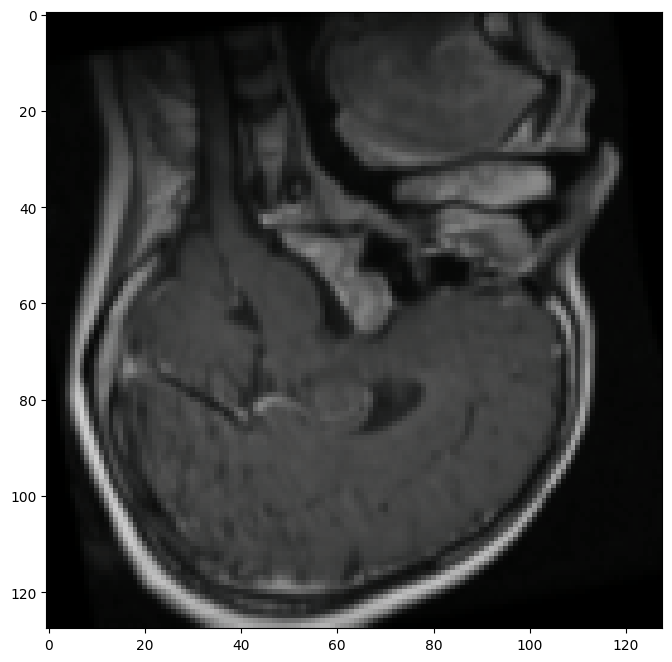

In [16]:
img_grid = make_grid(images,nrow=3)
inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_images = inv_normalize(images)

plt.figure(figsize=(12,8))
plt.imshow(np.transpose(inv_normalized_images.numpy(),axes=(1,2,0)));

## Defining CNN model architecture

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),stride=1) # 63,63,64
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=1) # 30,30,128
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1) # 14,14,256
        self.fc1 = nn.Linear(in_features=14*14*256,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=64)
        self.fc4 = nn.Linear(in_features=64,out_features=32)
        self.fc5 = nn.Linear(in_features=32,out_features=4)
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,14*14*256)
        X = F.relu(self.fc1(X))
        X = F.dropout(X,p=0.4)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,p=0.3)
        X = F.relu(self.fc3(X))
        X = F.dropout(X,p=0.2)
        X = F.relu(self.fc4(X))
        X = F.dropout(X,p=0.1)
        X = self.fc5(X)
        return F.log_softmax(X,dim=1)

In [18]:
torch.manual_seed(32)
cnn = CNN().cuda(device=device)
cnn

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=4, bias=True)
)

In [19]:
total_params = 0

for param in cnn.parameters():
    print(param.numel())
    total_params += param.numel()

print("Total CNN parameters:", total_params)

1728
64
73728
128
294912
256
12845056
256
32768
128
8192
64
2048
32
128
4
Total CNN parameters: 13259492


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn.parameters(),lr=0.001)

## Training and evaluating CNN model

In [21]:
epochs = 25

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0 

    for batch_no, (X_train,y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = cnn(X_train)
        loss = criterion(y_pred,y_train)
        predictions = torch.max(y_pred,1)[1]
        train_correct += (predictions == y_train).sum()

        # Reset gradients to zero to prevent them from accumulating
        optimizer.zero_grad()
        loss.backward() # Perform backpropagation
        optimizer.step() # Update weights and biases

        print(f"Epoch: {i} Batch: {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test,y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = cnn(X_test)
            predictions = torch.max(y_pred,1)[1]
            test_correct += (predictions == y_test).sum()  

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes.")

Epoch: 1 Batch: 1 -> Loss: 1.4174530506134033
Epoch: 1 Batch: 2 -> Loss: 1.4112508296966553
Epoch: 1 Batch: 3 -> Loss: 1.3678783178329468
Epoch: 1 Batch: 4 -> Loss: 1.3599580526351929
Epoch: 1 Batch: 5 -> Loss: 1.4585850238800049
Epoch: 1 Batch: 6 -> Loss: 1.3246182203292847
Epoch: 1 Batch: 7 -> Loss: 1.3228384256362915
Epoch: 1 Batch: 8 -> Loss: 1.3351197242736816
Epoch: 1 Batch: 9 -> Loss: 1.3525474071502686
Epoch: 1 Batch: 10 -> Loss: 1.560201644897461
Epoch: 1 Batch: 11 -> Loss: 1.388255000114441
Epoch: 1 Batch: 12 -> Loss: 1.3368911743164062
Epoch: 1 Batch: 13 -> Loss: 1.3918688297271729
Epoch: 1 Batch: 14 -> Loss: 1.3876087665557861
Epoch: 1 Batch: 15 -> Loss: 1.3676140308380127
Epoch: 1 Batch: 16 -> Loss: 1.3460019826889038
Epoch: 1 Batch: 17 -> Loss: 1.3609987497329712
Epoch: 1 Batch: 18 -> Loss: 1.345220685005188
Epoch: 1 Batch: 19 -> Loss: 1.3415567874908447
Epoch: 1 Batch: 20 -> Loss: 1.32417893409729
Epoch: 1 Batch: 21 -> Loss: 1.3300176858901978
Epoch: 1 Batch: 22 -> Loss:

## Visualizing model performance

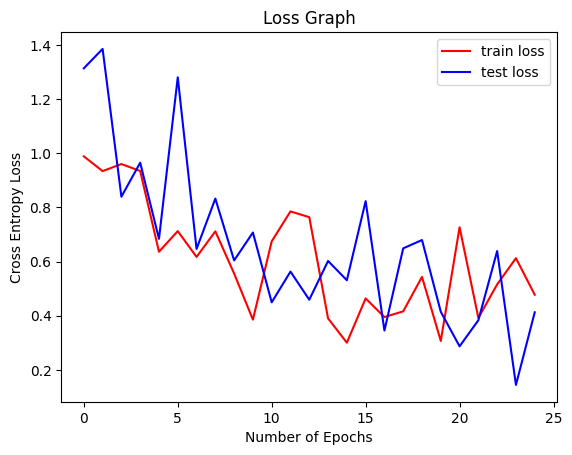

In [22]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

## Saving the model

In [23]:
torch.save(cnn,'brain_tumor_classifier.pt')

## Fine-tuning pretrained image classification models from torchvision

### AlexNet

In [33]:
alexnet = models.alexnet(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [34]:
total_params = 0

for param in alexnet.parameters():
    param.requires_grad = False  
    print(param.numel())
    total_params += param.numel()

print("Total Alexnet model parameters:", total_params)

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000
Total Alexnet model parameters: 61100840


In [35]:
alexnet.classifier = nn.Sequential(
    nn.Linear(in_features=9216,out_features=2048),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=2048,out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1024,out_features=4),
    nn.LogSoftmax(dim=1)
)
alexnet = alexnet.cuda()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alexnet.parameters(),lr=0.001)

In [37]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0 

    for batch_no, (X_train,y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predictions = torch.max(y_pred,1)[1]
        train_correct += (predictions == y_train).sum()

        # Reset gradients to zero to prevent them from accumulating
        optimizer.zero_grad()
        loss.backward() # Perform backpropagation
        optimizer.step() # Update weights and biases

        print(f"Epoch: {i} Batch: {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test,y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = alexnet(X_test)
            predictions = torch.max(y_pred,1)[1]
            test_correct += (predictions == y_test).sum()  

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in Alexnet model training: {(time.time()-start_time)/60} minutes.")

Epoch: 1 Batch: 1 -> Loss: 1.4001470804214478
Epoch: 1 Batch: 2 -> Loss: 4.070204734802246
Epoch: 1 Batch: 3 -> Loss: 16.569561004638672
Epoch: 1 Batch: 4 -> Loss: 12.668519973754883
Epoch: 1 Batch: 5 -> Loss: 9.73576831817627
Epoch: 1 Batch: 6 -> Loss: 3.753970146179199
Epoch: 1 Batch: 7 -> Loss: 2.9855425357818604
Epoch: 1 Batch: 8 -> Loss: 1.9079017639160156
Epoch: 1 Batch: 9 -> Loss: 1.5446697473526
Epoch: 1 Batch: 10 -> Loss: 1.8593547344207764
Epoch: 1 Batch: 11 -> Loss: 1.651373028755188
Epoch: 1 Batch: 12 -> Loss: 1.4545139074325562
Epoch: 1 Batch: 13 -> Loss: 1.1285945177078247
Epoch: 1 Batch: 14 -> Loss: 1.3437072038650513
Epoch: 1 Batch: 15 -> Loss: 1.2598741054534912
Epoch: 1 Batch: 16 -> Loss: 1.4125614166259766
Epoch: 1 Batch: 17 -> Loss: 1.399045705795288
Epoch: 1 Batch: 18 -> Loss: 1.0813895463943481
Epoch: 1 Batch: 19 -> Loss: 1.136055588722229
Epoch: 1 Batch: 20 -> Loss: 1.017411470413208
Epoch: 1 Batch: 21 -> Loss: 1.3081127405166626
Epoch: 1 Batch: 22 -> Loss: 1.207

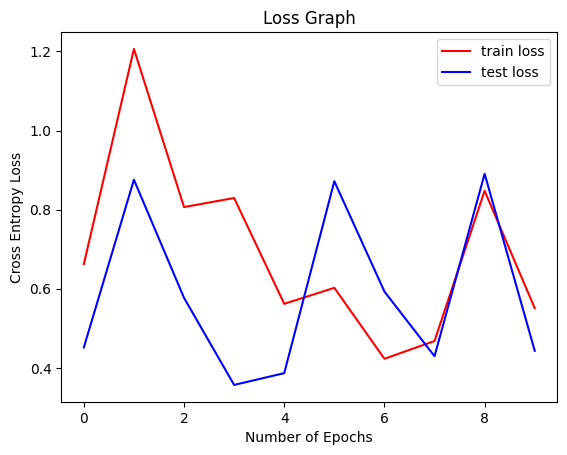

In [38]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [39]:
torch.save(alexnet,'brain_tumor_alexnet_classifier.pt')

### ResNet50

In [40]:
resnet = models.resnet50(pretrained=True)
resnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
total_params = 0

for param in resnet.parameters():
    param.requires_grad = False
    total_params += param.numel()

print("Total ResNet50 model parameters:", total_params)

Total ResNet50 model parameters: 25557032


In [42]:
resnet.fc = nn.Sequential(
    nn.Linear(in_features=2048,out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(in_features=1024,out_features=4),
    nn.LogSoftmax(dim=1)
)
resnet = resnet.cuda()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet.parameters(),lr=0.001)

In [44]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0 

    for batch_no, (X_train,y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = resnet(X_train)
        loss = criterion(y_pred,y_train)
        predictions = torch.max(y_pred,1)[1]
        train_correct += (predictions == y_train).sum()

        # Reset gradients to zero to prevent them from accumulating
        optimizer.zero_grad()
        loss.backward() # Perform backpropagation
        optimizer.step() # Update weights and biases

        print(f"Epoch: {i} Batch: {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test,y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = resnet(X_test)
            predictions = torch.max(y_pred,1)[1]
            test_correct += (predictions == y_test).sum()  

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in Resnet model training: {(time.time()-start_time)/60} minutes.")

Epoch: 1 Batch: 1 -> Loss: 1.4211781024932861
Epoch: 1 Batch: 2 -> Loss: 1.6969704627990723
Epoch: 1 Batch: 3 -> Loss: 2.396519899368286
Epoch: 1 Batch: 4 -> Loss: 1.2477478981018066
Epoch: 1 Batch: 5 -> Loss: 1.5154856443405151
Epoch: 1 Batch: 6 -> Loss: 1.313876986503601
Epoch: 1 Batch: 7 -> Loss: 1.476515293121338
Epoch: 1 Batch: 8 -> Loss: 1.0438692569732666
Epoch: 1 Batch: 9 -> Loss: 1.4978371858596802
Epoch: 1 Batch: 10 -> Loss: 1.116360068321228
Epoch: 1 Batch: 11 -> Loss: 1.2985669374465942
Epoch: 1 Batch: 12 -> Loss: 1.2975013256072998
Epoch: 1 Batch: 13 -> Loss: 1.0559829473495483
Epoch: 1 Batch: 14 -> Loss: 0.9131362438201904
Epoch: 1 Batch: 15 -> Loss: 1.2037789821624756
Epoch: 1 Batch: 16 -> Loss: 1.0845940113067627
Epoch: 1 Batch: 17 -> Loss: 0.9920340180397034
Epoch: 1 Batch: 18 -> Loss: 1.1524436473846436
Epoch: 1 Batch: 19 -> Loss: 1.3329066038131714
Epoch: 1 Batch: 20 -> Loss: 0.9627257585525513
Epoch: 1 Batch: 21 -> Loss: 0.7941619157791138
Epoch: 1 Batch: 22 -> Loss

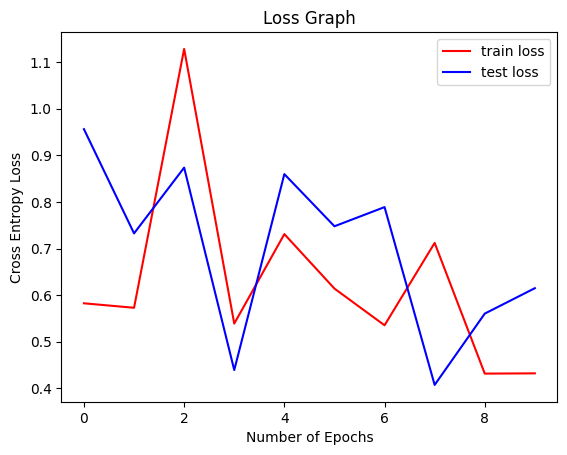

In [45]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [46]:
torch.save(resnet,'brain_tumor_resnet_classifier.pt')

### VGG16

In [58]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [59]:
total_params = 0

for param in vgg16.parameters():
    param.requires_grad = False
    total_params += param.numel()

print("Total VGG16 model parameters:", total_params)

Total VGG16 model parameters: 138357544


In [60]:
vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088,out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1024,out_features=4),
    nn.LogSoftmax(dim=1)
)
vgg16 = vgg16.cuda()
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg16.parameters(),lr=0.001)

In [62]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0 

    for batch_no, (X_train,y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = vgg16(X_train)
        loss = criterion(y_pred,y_train)
        predictions = torch.max(y_pred,1)[1]
        train_correct += (predictions == y_train).sum()

        # Reset gradients to zero to prevent them from accumulating
        optimizer.zero_grad()
        loss.backward() # Perform backpropagation
        optimizer.step() # Update weights and biases

        print(f"Epoch: {i} Batch: {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test,y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = vgg16(X_test)
            predictions = torch.max(y_pred,1)[1]
            test_correct += (predictions == y_test).sum()  

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in VGG16 model training: {(time.time()-start_time)/60} minutes.")

Epoch: 1 Batch: 1 -> Loss: 1.3222506046295166
Epoch: 1 Batch: 2 -> Loss: 17.624563217163086
Epoch: 1 Batch: 3 -> Loss: 12.015412330627441
Epoch: 1 Batch: 4 -> Loss: 9.356080055236816
Epoch: 1 Batch: 5 -> Loss: 8.255556106567383
Epoch: 1 Batch: 6 -> Loss: 3.726842164993286
Epoch: 1 Batch: 7 -> Loss: 3.499713897705078
Epoch: 1 Batch: 8 -> Loss: 3.7575647830963135
Epoch: 1 Batch: 9 -> Loss: 2.7390260696411133
Epoch: 1 Batch: 10 -> Loss: 2.852677822113037
Epoch: 1 Batch: 11 -> Loss: 2.3350348472595215
Epoch: 1 Batch: 12 -> Loss: 1.4270962476730347
Epoch: 1 Batch: 13 -> Loss: 2.5158286094665527
Epoch: 1 Batch: 14 -> Loss: 0.8961343765258789
Epoch: 1 Batch: 15 -> Loss: 1.8233367204666138
Epoch: 1 Batch: 16 -> Loss: 1.9326053857803345
Epoch: 1 Batch: 17 -> Loss: 0.9383051991462708
Epoch: 1 Batch: 18 -> Loss: 0.8686746954917908
Epoch: 1 Batch: 19 -> Loss: 1.0185599327087402
Epoch: 1 Batch: 20 -> Loss: 1.27708101272583
Epoch: 1 Batch: 21 -> Loss: 1.3107577562332153
Epoch: 1 Batch: 22 -> Loss: 1

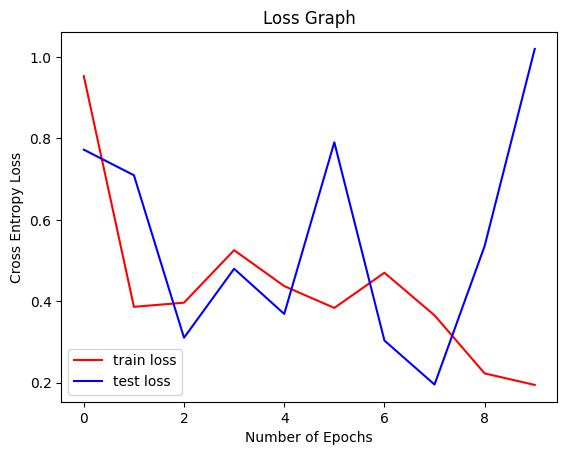

In [63]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [64]:
torch.save(vgg16,'brain_tumor_vgg16_classifier.pt')

### MobileNet v3 large

In [66]:
mobilenet = models.mobilenet_v3_large(pretrained=True)
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [67]:
total_params = 0

for param in mobilenet.parameters():
    print(param.numel())
    total_params += param.numel()

print("Total MobileNet v3 parameters:", total_params)

432
16
16
144
16
16
256
16
16
1024
64
64
576
64
64
1536
24
24
1728
72
72
648
72
72
1728
24
24
1728
72
72
1800
72
72
1728
24
1728
72
2880
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
9600
240
240
2160
240
240
19200
80
80
16000
200
200
1800
200
200
16000
80
80
14720
184
184
1656
184
184
14720
80
80
14720
184
184
1656
184
184
14720
80
80
38400
480
480
4320
480
480
57600
120
57600
480
53760
112
112
75264
672
672
6048
672
672
112896
168
112896
672
75264
112
112
75264
672
672
16800
672
672
112896
168
112896
672
107520
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
1228800
1280
1280000
1000
Total MobileNet v3 parameters: 5483032


In [68]:
mobilenet.classifier = nn.Sequential(
    nn.Linear(in_features=960,out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(in_features=1024,out_features=4),
    nn.LogSoftmax(dim=1)
)
mobilenet = mobilenet.cuda()
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=mobilenet.parameters(),lr=0.001)

In [70]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0 

    for batch_no, (X_train,y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = mobilenet(X_train)
        loss = criterion(y_pred,y_train)
        predictions = torch.max(y_pred,1)[1]
        train_correct += (predictions == y_train).sum()

        # Reset gradients to zero to prevent them from accumulating
        optimizer.zero_grad()
        loss.backward() # Perform backpropagation
        optimizer.step() # Update weights and biases

        print(f"Epoch: {i} Batch: {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test,y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = mobilenet(X_test)
            predictions = torch.max(y_pred,1)[1]
            test_correct += (predictions == y_test).sum()  

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in MobileNet v3 large model training: {(time.time()-start_time)/60} minutes.")

Epoch: 1 Batch: 1 -> Loss: 1.3721377849578857
Epoch: 1 Batch: 2 -> Loss: 1.4841557741165161
Epoch: 1 Batch: 3 -> Loss: 1.235729694366455
Epoch: 1 Batch: 4 -> Loss: 0.8772896528244019
Epoch: 1 Batch: 5 -> Loss: 0.9933590292930603
Epoch: 1 Batch: 6 -> Loss: 1.0050095319747925
Epoch: 1 Batch: 7 -> Loss: 0.7946802973747253
Epoch: 1 Batch: 8 -> Loss: 0.6781291961669922
Epoch: 1 Batch: 9 -> Loss: 0.9272663593292236
Epoch: 1 Batch: 10 -> Loss: 0.7833054661750793
Epoch: 1 Batch: 11 -> Loss: 0.552052915096283
Epoch: 1 Batch: 12 -> Loss: 0.672080397605896
Epoch: 1 Batch: 13 -> Loss: 0.6483335494995117
Epoch: 1 Batch: 14 -> Loss: 0.3738970458507538
Epoch: 1 Batch: 15 -> Loss: 0.578481912612915
Epoch: 1 Batch: 16 -> Loss: 0.347212016582489
Epoch: 1 Batch: 17 -> Loss: 0.7089580297470093
Epoch: 1 Batch: 18 -> Loss: 0.8040030598640442
Epoch: 1 Batch: 19 -> Loss: 0.8357222676277161
Epoch: 1 Batch: 20 -> Loss: 0.3814602494239807
Epoch: 1 Batch: 21 -> Loss: 0.2805733382701874
Epoch: 1 Batch: 22 -> Loss:

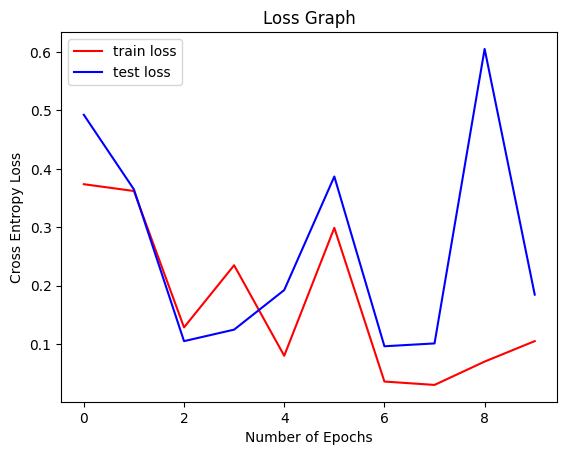

In [71]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [72]:
torch.save(mobilenet,'brain_tumor_mobilenet_classifier.pt')

### DenseNet 121

In [73]:
densenet = models.densenet121(pretrained=True)
densenet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 157MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [74]:
total_params = 0

for param in densenet.parameters():
    param.requires_grad = False
    total_params += param.numel()

print("Total Densenet 121 model parameters:", total_params)

Total Densenet 121 model parameters: 7978856


In [76]:
densenet.classifier = nn.Sequential(
    nn.Linear(in_features=1024,out_features=4),
    nn.LogSoftmax(dim=1)
)
densenet = densenet.cuda()
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=densenet.parameters(),lr=0.001)

In [78]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0 

    for batch_no, (X_train,y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = densenet(X_train)
        loss = criterion(y_pred,y_train)
        predictions = torch.max(y_pred,1)[1]
        train_correct += (predictions == y_train).sum()

        # Reset gradients to zero to prevent them from accumulating
        optimizer.zero_grad()
        loss.backward() # Perform backpropagation
        optimizer.step() # Update weights and biases

        print(f"Epoch: {i} Batch: {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test,y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = densenet(X_test)
            predictions = torch.max(y_pred,1)[1]
            test_correct += (predictions == y_test).sum()  

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in Densenet 121 model training: {(time.time()-start_time)/60} minutes.")

Epoch: 1 Batch: 1 -> Loss: 1.4948419332504272
Epoch: 1 Batch: 2 -> Loss: 1.46982741355896
Epoch: 1 Batch: 3 -> Loss: 1.4122226238250732
Epoch: 1 Batch: 4 -> Loss: 1.344840407371521
Epoch: 1 Batch: 5 -> Loss: 1.2900707721710205
Epoch: 1 Batch: 6 -> Loss: 1.4605821371078491
Epoch: 1 Batch: 7 -> Loss: 1.319334626197815
Epoch: 1 Batch: 8 -> Loss: 1.2074649333953857
Epoch: 1 Batch: 9 -> Loss: 1.2498921155929565
Epoch: 1 Batch: 10 -> Loss: 1.265856146812439
Epoch: 1 Batch: 11 -> Loss: 1.2443110942840576
Epoch: 1 Batch: 12 -> Loss: 1.2314101457595825
Epoch: 1 Batch: 13 -> Loss: 1.3422980308532715
Epoch: 1 Batch: 14 -> Loss: 1.1498045921325684
Epoch: 1 Batch: 15 -> Loss: 1.1561622619628906
Epoch: 1 Batch: 16 -> Loss: 1.02423894405365
Epoch: 1 Batch: 17 -> Loss: 1.1367777585983276
Epoch: 1 Batch: 18 -> Loss: 0.9642342329025269
Epoch: 1 Batch: 19 -> Loss: 1.1758818626403809
Epoch: 1 Batch: 20 -> Loss: 1.1278820037841797
Epoch: 1 Batch: 21 -> Loss: 1.0373806953430176
Epoch: 1 Batch: 22 -> Loss: 1

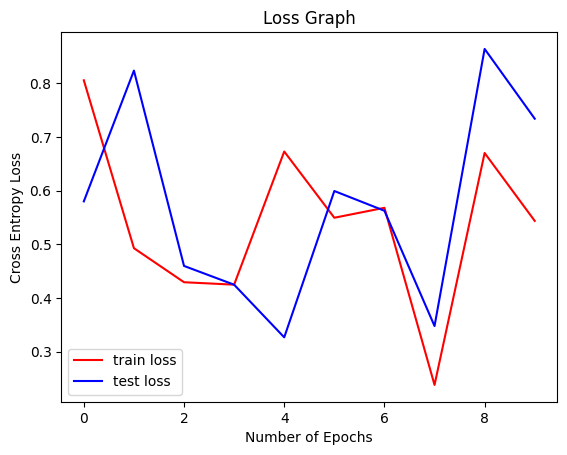

In [79]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [80]:
torch.save(densenet,'brain_tumor_densenet_classifier.pt')

## Evaluating all models on testing data

In [84]:
def test_single_image(image_path,model,device,class_to_idx):
    img = Image.open(image_path).convert("RGB")
    transformed_img = img_transforms(img)
    transformed_img = transformed_img.unsqueeze(0).to(device=device)
    model.eval() # Set model to evaluation mode

    with torch.no_grad():
        prediction = model(transformed_img)
        predicted_idx = torch.max(prediction,1)[1]

    idx_to_class = {v: k for k, v in class_to_idx.items()}
    return idx_to_class[predicted_idx.item()]

In [141]:
def evaluate_model_performance(model):
    test_accuracies = []
    
    for label in list(train_set.class_to_idx.keys()):
         correct_predictions = 0
         class_dir = f"/kaggle/input/brain-tumor-classification-mri/Testing/{label}/"
         for img_filepath in os.listdir(class_dir):
            img_filepath = os.path.join(class_dir + str(img_filepath))
            predicted_class = test_single_image(img_filepath,model,device,train_set.class_to_idx)
            if predicted_class == label:
                correct_predictions += 1
         test_accuracies.append(correct_predictions/len(os.listdir(class_dir)))
    
    print(f"Mean accuracy on the test set: {round(np.mean(test_accuracies)*100,2)}%")

In [142]:
evaluate_model_performance(cnn)

Mean accuracy on the test set: 55.7%


In [143]:
evaluate_model_performance(alexnet)

Mean accuracy on the test set: 55.46%


In [144]:
evaluate_model_performance(resnet)

Mean accuracy on the test set: 55.72%


In [145]:
evaluate_model_performance(mobilenet)

Mean accuracy on the test set: 69.01%


In [146]:
evaluate_model_performance(vgg16)

Mean accuracy on the test set: 68.43%


In [147]:
evaluate_model_performance(densenet)

Mean accuracy on the test set: 53.26%


The MobileNet v3 large model has the best performance with an average test accuracy of approximately 69%, closely followed by the VGG16 model.